In [4]:
import matplotlib.pyplot as plt
from pylab import mpl

# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]

def plot(file,title,peak_file=None):
    with open(file, "r") as f:
        lines = f.readlines()
        data = [int(line.strip()) for line in lines]
        print("counts:",sum(data))
    plt.plot(data)
    if peak_file:
        with open(peak_file, "r") as f:
            lines = f.readlines()
            peaks = [int(line.strip()) for line in lines]
            for peak in peaks:
                plt.axvline(x=peak, color='r')
    plt.title(title)
    plt.show()
    return data

## 对称零面积法寻峰

In [5]:
import math

import numpy as np


class SymmetricZeroAreaPeaking:
    def __init__(self, W=60, HL=20, HG=40, percent=75, threshold=50):
        self.W = W
        self.HL = HL
        self.HG = HG
        self.m = W // 2
        self.g = np.zeros(W + 1)
        self.d = 0

        for i in range(-self.m, self.m + 1):
            self.g[i + self.m] = self.G(i)
            self.d += self.g[i + self.m]

        self.d /= W

        if percent < 0:
            self.percent = 0
        elif percent > 100:
            self.percent = 100
        else:
            self.percent = percent

        self.threshold = threshold

    def WindowFunction(self, j):
        return self.g[j + self.m] - self.d

    def G(self, i):
        Voigt_k = 0.5
        return (2 * Voigt_k * self.HL / (4 * i * i + self.HL * self.HL) / math.pi +
                (1 - Voigt_k) * math.sqrt(4 * math.log(2)) / math.sqrt(math.pi) / self.HG *
                math.exp(-4 * math.log(2) * i * i / self.HG / self.HG))

    def Apply(self, data):
        n = len(data)
        Y = np.zeros(n)
        deltaY = np.zeros(n)
        Ss = np.zeros(n)
        Score = np.zeros(n)

        temp = []
        peaks = []

        for i in range(self.m, n - self.m):
            sumY = 0
            sumdeltaY = 0
            for j in range(-self.m, self.m + 1):
                C = self.WindowFunction(j)
                sumY += data[i + j] * C
                sumdeltaY += data[i + j] * C * C

            Y[i] = sumY
            deltaY[i] = sumdeltaY
            if deltaY[i] != 0:
                Ss[i] = Y[i] / deltaY[i]

        IMax = np.max(data)
        SSMax = np.max(Ss)

        for i in range(self.m, n - self.m):
            Score[i] = self.percent * Ss[i] / SSMax + \
                (100 - self.percent) * data[i] / IMax
                
        plt.plot(Score, label="Score")

        temp = NonMaximumSuppression.Apply(Score, self.threshold)
        for i in temp:
            peaks.append(i)

        return peaks


class NonMaximumSuppression:
    @staticmethod
    def Apply(data, threshold):
        n = len(data)
        result = []
        for i in range(1, n - 1):
            if data[i] >= data[i - 1] and data[i] >= data[i + 1] and data[i] >= threshold:
                result.append(i)
        return result
    
def plot_peaks(data, peaks, title):
    plt.plot(data, label="Data")
    for peak in peaks:
        plt.axvline(x=peak, color='r')
    plt.title(title)
    plt.show()

counts: 4812057


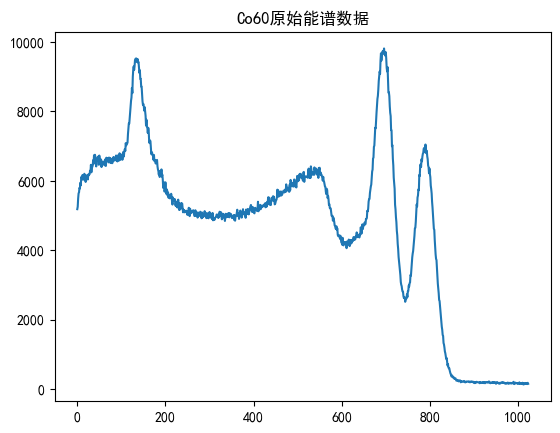

counts: 1499410


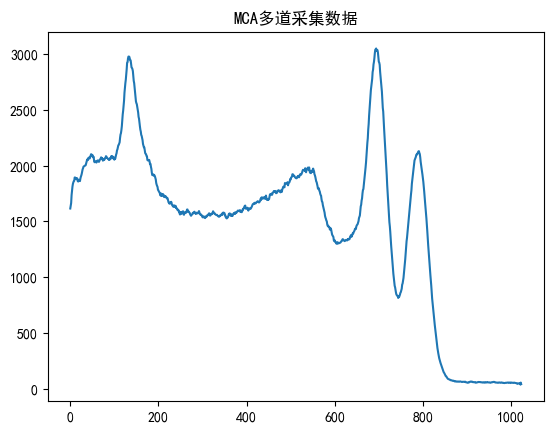

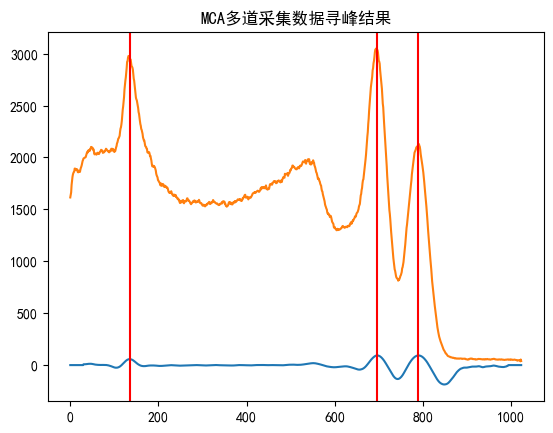

In [6]:
if __name__ == "__main__":
    origin = plot("data/Co.txt", "Co60原始能谱数据")
    mca = plot("data/out.hex", "MCA多道采集数据", "data/peak.hex")
    
    find_peak = SymmetricZeroAreaPeaking()
    peaks = find_peak.Apply(mca)
    plot_peaks(mca, peaks, "MCA多道采集数据寻峰结果")